In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd
from pandas_datareader import data
import pickle
import logging
from tqdm._tqdm_notebook import tqdm.notebook.*
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

C:\Users\pcosm\AppData\Local\Temp/ipykernel_12824/467202958.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
data_inicio = '2010-01-01'
data_fim = '2021-09-06'

In [3]:
df = data.DataReader('petr4.sa', 'yahoo', data_inicio, data_fim)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,37.320000,36.820000,36.950001,37.320000,13303600.0,26.560331
2010-01-05,37.430000,36.799999,37.380001,37.000000,21396400.0,26.332596
2010-01-06,37.500000,36.799999,36.799999,37.500000,18720600.0,26.688438
2010-01-07,37.450001,37.070000,37.270000,37.150002,10964600.0,26.439348
2010-01-08,37.389999,36.860001,37.160000,36.950001,14624200.0,26.297009
...,...,...,...,...,...,...
2021-08-31,28.230000,26.990000,28.200001,27.190001,110574300.0,27.190001
2021-09-01,27.340000,26.330000,27.320000,27.040001,69430400.0,27.040001
2021-09-02,27.350000,26.459999,27.000000,26.600000,56052000.0,26.600000


In [4]:
df['data_pregao'] = df.index
df['mm5D'] = df['Close'].rolling(5).mean()
df['mm21D'] = df['Close'].rolling(21).mean()
df.dropna(inplace=True)
df

,High,Low,Open,Close,Volume,Adj Close,data_pregao,mm5D,mm21D
Date,,,,,,,,,
2010-02-02,34.669998,34.060001,34.509998,34.099998,15289600.0,24.268684,2010-02-02,34.257999,35.689524
2010-02-03,34.180000,33.730000,34.049999,34.040001,16091200.0,24.225990,2010-02-03,34.243999,35.533334
2010-02-04,33.939999,32.119999,33.840000,32.299999,24280300.0,22.987642,2010-02-04,33.781999,35.309524
2010-02-05,32.270000,30.719999,31.799999,31.520000,29033800.0,22.432520,2010-02-05,33.252000,35.024762
2010-02-08,32.259998,31.420000,31.799999,31.740000,18684700.0,22.589090,2010-02-08,32.740000,34.767143
...,...,...,...,...,...,...,...,...,...
2021-08-31,28.230000,26.990000,28.200001,27.190001,110574300.0,27.190001,2021-08-31,27.840000,27.760000
2021-09-01,27.340000,26.330000,27.320000,27.040001,69430400.0,27.040001,2021-09-01,27.702000,27.769048
2021-09-02,27.350000,26.459999,27.000000,26.600000,56052000.0,26.600000,2021-09-02,27.524000,27.784286


In [5]:
df_train, df_test = train_test_split(df, 
                                     train_size=0.8, 
                                     test_size=0.2, 
                                     shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

Train--Test size 2298 575


In [6]:
train_cols = ["Open", "High", "Low", "Close", "Volume", 'mm5D', 'mm21D']
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [7]:
train_cols

['Open', 'High', 'Low', 'Close', 'Volume', 'mm5D', 'mm21D']

In [20]:
TIME_STEPS

15

In [11]:
params = {
"batch_size": 20,
"epochs": 60,
"lr": 0.00010000,
"time_steps": 15
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
def trim_dataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    return x, y
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Train size", x_t.shape, y_t.shape)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

  0%|          | 0/2283 [00:00<?, ?it/s]

Train size (2280, 15, 7) (2280,)


  0%|          | 0/560 [00:00<?, ?it/s]

Test size (280, 15, 7) (280,) (280, 15, 7) (280,)


In [13]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, 
                        recurrent_dropout=0.0, 
                        stateful=True, 
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model
print("Building model...")    
model = create_model()
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es])

Building model...
Epoch 1/60


C:\Users\pcosm\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


114/114 - 2s - loss: 0.0388 - val_loss: 0.0629
Epoch 2/60
114/114 - 0s - loss: 0.0387 - val_loss: 0.0650
Epoch 3/60
114/114 - 0s - loss: 0.0317 - val_loss: 0.0333
Epoch 4/60
114/114 - 0s - loss: 0.0169 - val_loss: 0.0168
Epoch 5/60
114/114 - 0s - loss: 0.0120 - val_loss: 0.0151
Epoch 6/60
114/114 - 0s - loss: 0.0102 - val_loss: 0.0142
Epoch 7/60
114/114 - 0s - loss: 0.0092 - val_loss: 0.0133
Epoch 8/60
114/114 - 0s - loss: 0.0084 - val_loss: 0.0125
Epoch 9/60
114/114 - 0s - loss: 0.0077 - val_loss: 0.0115
Epoch 10/60
114/114 - 0s - loss: 0.0071 - val_loss: 0.0108
Epoch 11/60
114/114 - 0s - loss: 0.0066 - val_loss: 0.0100
Epoch 12/60
114/114 - 0s - loss: 0.0057 - val_loss: 0.0093
Epoch 13/60
114/114 - 0s - loss: 0.0053 - val_loss: 0.0084
Epoch 14/60
114/114 - 0s - loss: 0.0050 - val_loss: 0.0076
Epoch 15/60
114/114 - 0s - loss: 0.0047 - val_loss: 0.0070
Epoch 16/60
114/114 - 0s - loss: 0.0042 - val_loss: 0.0063
Epoch 17/60
114/114 - 0s - loss: 0.0038 - val_loss: 0.0057
Epoch 18/60
114/1

In [14]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is: ", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is:  0.0022788283003415608 (280,) (280,)
[0.6260883  0.6264539  0.6291796  0.63113457 0.6312934  0.6299289
 0.6301823  0.6300391  0.63028306 0.6289225  0.6267594  0.6215238
 0.6144078  0.61360097 0.6156895 ]
[0.561648   0.58073316 0.57103907 0.55649804 0.56134505 0.5755832
 0.56346561 0.57467436 0.5640715  0.54528935 0.53317176 0.53256593
 0.57497731 0.57618903 0.56316272]


In [15]:
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[24.867176 24.879242 24.969215 25.033752 25.038994 24.99395  25.002316
 24.99759  25.005642 24.960732 24.889328 24.7165   24.481598 24.454967
 24.52391 ]
[22.73999977 23.37000084 23.04999924 22.56999969 22.72999954 23.20000076
 22.79999924 23.17000008 22.81999969 22.20000076 21.79999924 21.78000069
 23.18000031 23.21999931 22.79000092]


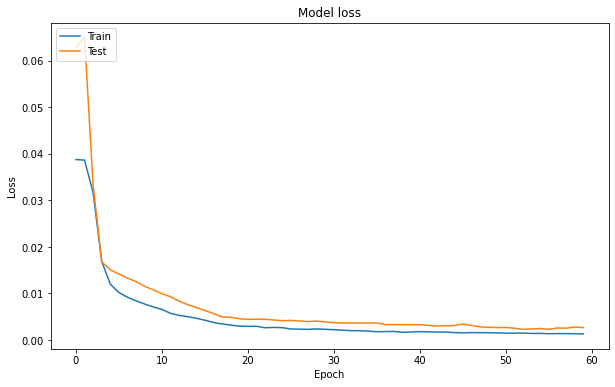

In [16]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

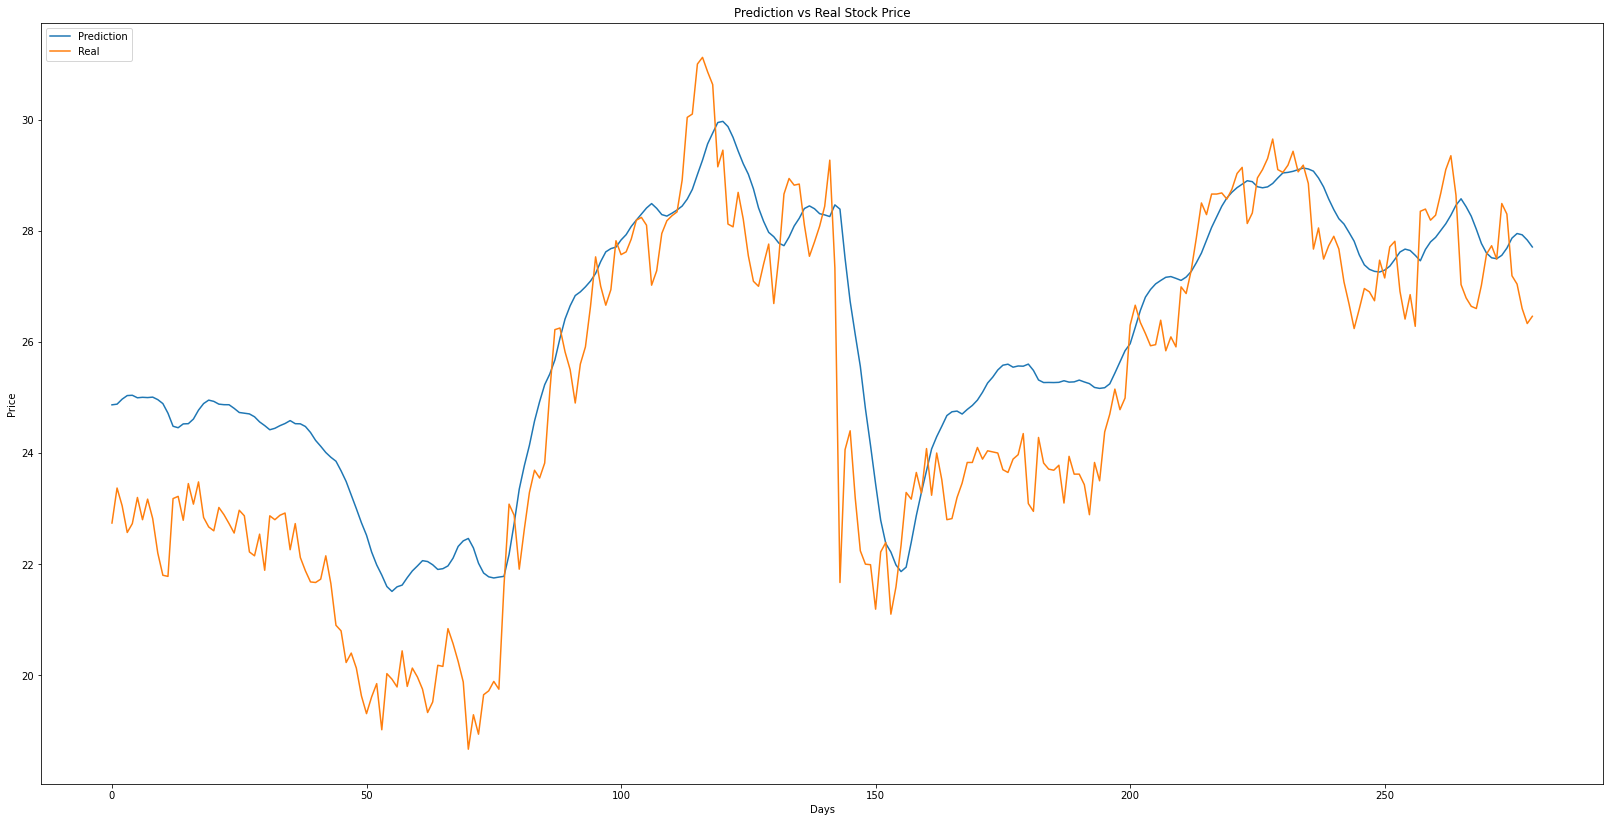

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(28,14))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()